<a href="https://colab.research.google.com/github/KaterinaVat/PINNs/blob/main/pinns27_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam

DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [2]:
class Net(torch.nn.Module):
  def __init__(self, indim = 1, outdim =1):
    super().__init__()
    self.actf = torch.tanh
    self.lin1 = torch.nn.Linear(indim, 100)
    self.lin2 = torch.nn.Linear(100, 100)
    self.lin3 = torch.nn.Linear(100, outdim)

  def forward(self, x):
    x = self.lin1(x)
    x = self.lin2(self.actf(x))
    x = self.lin3(self.actf(x))
    return x.squeeze()

In [3]:
class MyData(Dataset):
  def __init__(self, in_tensor, out_tensor):
    self.inp = in_tensor
    self.out = out_tensor

  def __len__(self):
    return len(self.inp)

  def __getitem__(self, idx):
    return self.inp[idx], self.out[idx]

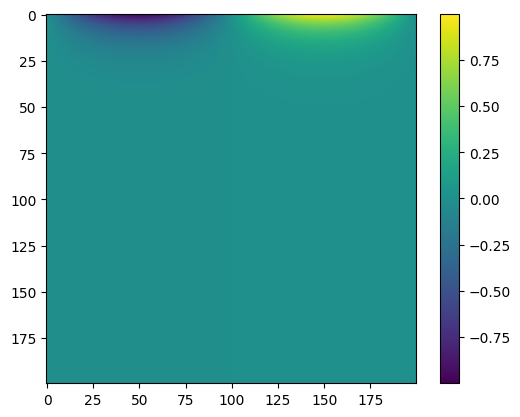

In [4]:
#generating dataset
def u(x,t):
  return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0, 1, pts)
xs = np.linspace(-1, 1, pts)

X,T = np.meshgrid(xs, ts)
U = u(X,T)
plt.imshow(U)
plt.colorbar()

In [5]:
#формирование датасета для обучения
# флаттен это преобразование структуры в список не содержащий вложенных элементов
train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype = torch.float32)
# u - действительное значение функции
# a = np.array([[1, 2],[3, 4]])
#  array([1, 2, 3, 4])

# перенос обучения на устройство
train_in.to(DEVICE)
train_out.to(DEVICE)

train_dataset = MyData(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)

In [6]:
model = Net(indim=2, outdim=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fcn = torch.nn.MSELoss()
epochs = 100

loss_history = []
rel_error_history = []

for epoch in range(epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in.requires_grad_()
        batch_in, batch_out = batch_in.to(DEVICE), batch_out.to(DEVICE)
        model.train()
        def closure():
          optimizer.zero_grad()
          pred = model(batch_in)
          loss = loss_fcn(pred, batch_out)
          loss.backward()
          return loss
        optimizer.step(closure)

    model.eval()
    epoch_loss = loss_fcn(model(train_in), train_out)
    loss_history.append(epoch_loss.item())
    rel_error = torch.norm(model(train_in)- train_out)/torch.norm(train_out)
    rel_error_history.append(rel_error.item())
    if epoch%10==0:
      print(f"Epoch: {epoch+1} | Loss: {epoch_loss:.10f} | Rel. Error: {rel_error:.10f}")

Epoch: 1 | Loss: 0.0107961521 | Rel. Error: 0.8837382197
Epoch: 11 | Loss: 0.0011418170 | Rel. Error: 0.2874006927
Epoch: 21 | Loss: 0.0001866048 | Rel. Error: 0.1161852181
Epoch: 31 | Loss: 0.0000988559 | Rel. Error: 0.0845650584
Epoch: 41 | Loss: 0.0000553833 | Rel. Error: 0.0632963628
Epoch: 51 | Loss: 0.0000382987 | Rel. Error: 0.0526357964
Epoch: 61 | Loss: 0.0000282619 | Rel. Error: 0.0452157930
Epoch: 71 | Loss: 0.0000190772 | Rel. Error: 0.0371489674
Epoch: 81 | Loss: 0.0000798179 | Rel. Error: 0.0759870782
Epoch: 91 | Loss: 0.0000334670 | Rel. Error: 0.0492036864


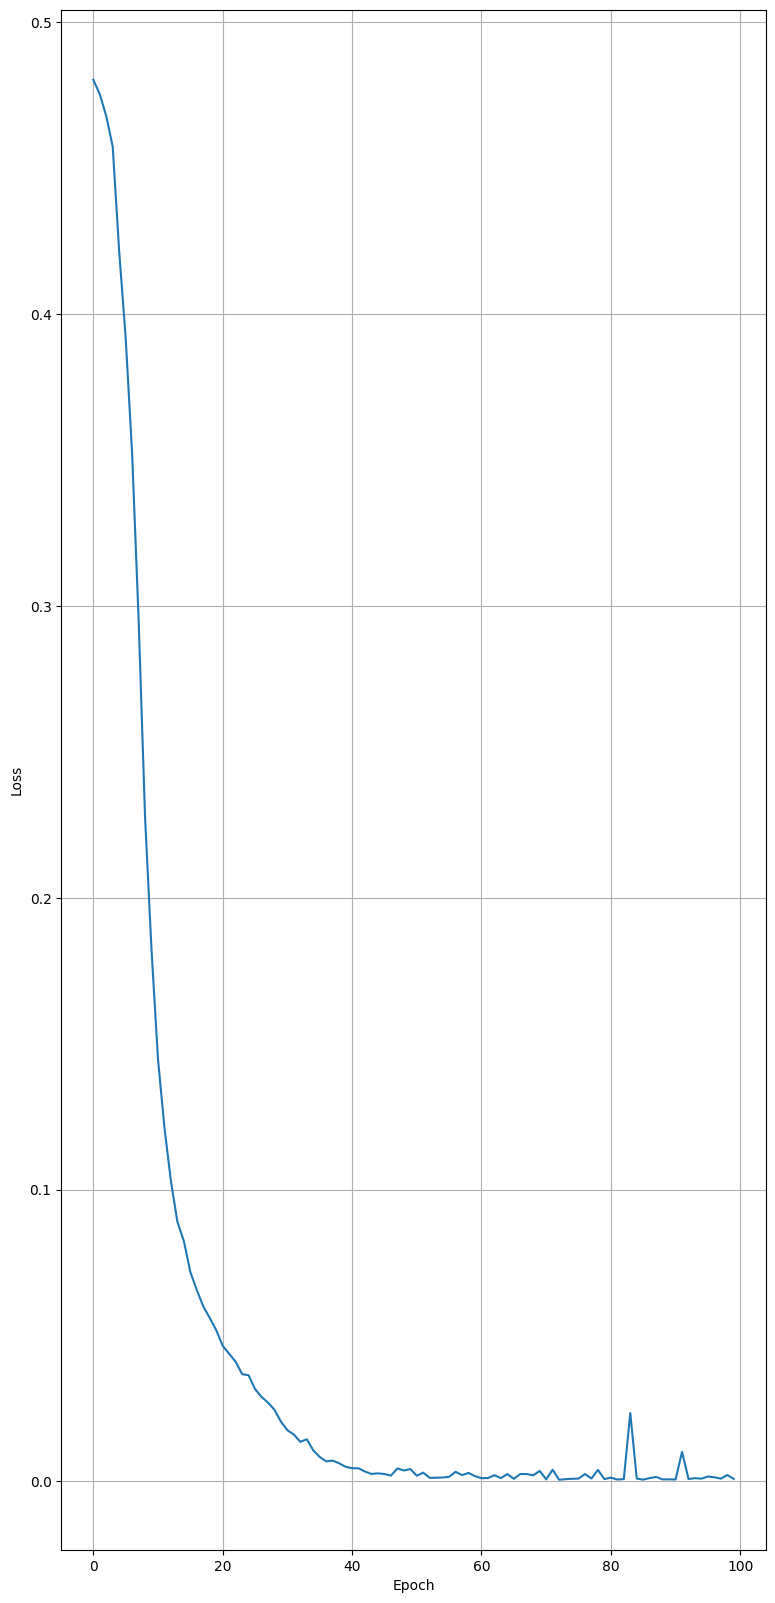

In [21]:
# График функции потерь
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

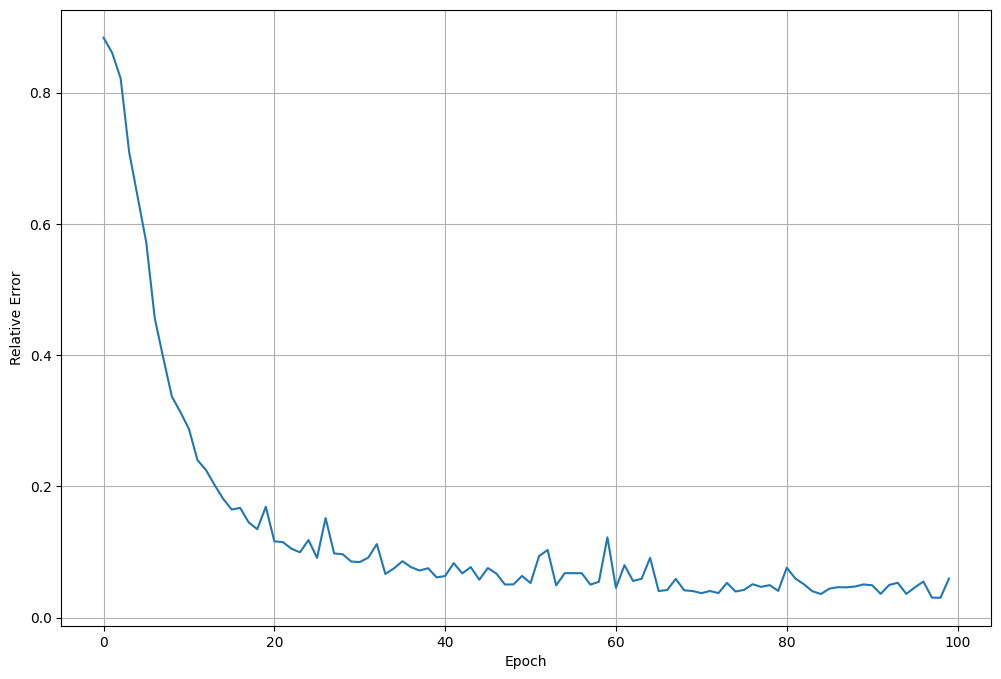

In [8]:
# График относительной ошибки
plt.figure(figsize=(12,8))
plt.plot(rel_error_history, label="Relative Error (L2)")
plt.xlabel("Epoch")
plt.ylabel("Relative Error")
plt.grid(True)
plt.show()

что даст нам обученная ранее моделька

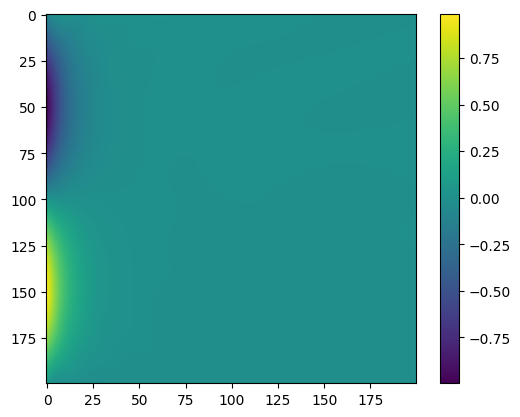

In [10]:
def u_model(xs, ts):
  pts = torch.tensor(np.array([[x,t] for x,t in zip(xs, ts)]), dtype = torch.float32)
  return model(pts)

pts = 200
ts = np.linspace(0, 1, pts)
xs = np.linspace(-1, 1, pts)
X, T = np.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x,t in zip(X,T):
  img.append(u_model(x,t).detach().numpy().tolist())
  # детач дает возможность просто сохранить результат а не обучать модель

plt.imshow(img)
plt.colorbar()

начнем пинны

In [11]:
from torch.autograd import grad
# d²u/dx² = 0.5 * du/dt

def phys_loss(inp, out):
  # inp - переменная по которой берется производные - то есть x и t (нужно чтобы брать градиенты по входам)
  # out - предсказание модели. то, по чему берется прозводные du/dx, du^2/dx^2, du/dt
    dudt = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,1]
    dudx = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,0]
    d2udx2 = grad(dudx, inp, grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,0]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

добавление граничных точек
t = 0

In [24]:
bdry_pts = 200
xs_bdry = np.linspace(-1, 1, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])

us_bdry = u(xs_bdry, ts_bdry)

train_in_bd = torch.tensor([[x,t] for x, t in zip(xs_bdry, ts_bdry)],  dtype=torch.float32, requires_grad=True)
train_out_bd = torch.tensor(us_bdry, dtype = torch.float32)

train_in_bd.to(DEVICE)
train_out_bd.to(DEVICE)

tensor([-1.2246e-16, -3.1569e-02, -6.3106e-02, -9.4580e-02, -1.2596e-01,
        -1.5721e-01, -1.8831e-01, -2.1922e-01, -2.4991e-01, -2.8036e-01,
        -3.1052e-01, -3.4037e-01, -3.6989e-01, -3.9903e-01, -4.2778e-01,
        -4.5610e-01, -4.8397e-01, -5.1135e-01, -5.3822e-01, -5.6456e-01,
        -5.9034e-01, -6.1552e-01, -6.4010e-01, -6.6403e-01, -6.8730e-01,
        -7.0989e-01, -7.3177e-01, -7.5292e-01, -7.7332e-01, -7.9295e-01,
        -8.1179e-01, -8.2982e-01, -8.4702e-01, -8.6338e-01, -8.7888e-01,
        -8.9350e-01, -9.0723e-01, -9.2006e-01, -9.3197e-01, -9.4295e-01,
        -9.5299e-01, -9.6208e-01, -9.7021e-01, -9.7738e-01, -9.8357e-01,
        -9.8877e-01, -9.9300e-01, -9.9623e-01, -9.9847e-01, -9.9972e-01,
        -9.9997e-01, -9.9922e-01, -9.9748e-01, -9.9474e-01, -9.9101e-01,
        -9.8629e-01, -9.8059e-01, -9.7391e-01, -9.6627e-01, -9.5765e-01,
        -9.4809e-01, -9.3758e-01, -9.2613e-01, -9.1376e-01, -9.0048e-01,
        -8.8630e-01, -8.7124e-01, -8.5531e-01, -8.3

In [13]:
from torch.autograd import Variable

In [25]:

model_pinn = Net(indim=2, outdim=1).to(DEVICE)
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=0.001)
loss_fcn = torch.nn.MSELoss()

loss_history = []
base_loss_history = []
phy_loss_history = []
bdry_loss_history = []
rel_error_history = []
phy_error_history = []

for epoch in range(epochs):
    model_pinn.train()

    for batch_in, batch_out in train_dataloader:
        batch_in = batch_in.to(DEVICE).requires_grad_(True)
        batch_out = batch_out.to(DEVICE)

        optimizer_pinn.zero_grad()
        pred = model_pinn(batch_in).squeeze()

        base_loss = loss_fcn(pred, batch_out)
        phy_loss = phys_loss(batch_in, pred)
        bdry_pred = model_pinn(train_in_bd.to(DEVICE))
        bdry_loss = loss_fcn(bdry_pred, train_out_bd.to(DEVICE))

        total_loss = base_loss + phy_loss + bdry_loss
        total_loss.backward()
        optimizer_pinn.step()

    model_pinn.eval()
    with torch.no_grad():

        pred = model_pinn(train_in.to(DEVICE)).squeeze()
        base_loss = loss_fcn(pred, train_out.to(DEVICE))
        rel_error_data = torch.norm(pred - train_out.to(DEVICE)) / torch.norm(train_out.to(DEVICE))

        pred_bd = model_pinn(train_in_bd.to(DEVICE))
        bdry_loss = loss_fcn(pred_bd, train_out_bd.to(DEVICE))
        rel_error_bdry = torch.norm(pred_bd - train_out_bd.to(DEVICE)) / torch.norm(train_out_bd.to(DEVICE))


        rel_error = rel_error_data + rel_error_bdry


    model_pinn.eval()  # Но с включенными градиентами
    train_in_phy = train_in.to(DEVICE).requires_grad_(True)
    with torch.enable_grad():
        phy_pred = model_pinn(train_in_phy)
        phy_loss_value = phys_loss(train_in_phy, phy_pred)
        phy_error = torch.norm(phy_loss_value) / (torch.norm(phy_pred))


    total_loss = base_loss + phy_loss_value + bdry_loss
    loss_history.append(total_loss.item())
    base_loss_history.append(base_loss.item())
    phy_loss_history.append(phy_loss_value.item())
    bdry_loss_history.append(bdry_loss.item())
    rel_error_history.append(rel_error.item())
    phy_error_history.append(phy_error.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1:3d} | Loss: {total_loss.item():.10f} '
              f'= Data: {base_loss.item():.10f} '
              f'+ Physics: {phy_loss_value.item():.10f} '
              f'+ Boundary: {bdry_loss.item():.10f} '
              f'| Rel Error: {rel_error.item():.10f} '
              f'| Phy Error: {phy_error.item():.10f}')

Epoch:  10 | Loss: 0.0069525749 = Data: 0.0006564924 + Physics: 0.0039995699 + Boundary: 0.0022965125 | Rel Error: 0.2858655155 | Phy Error: 0.0001709789
Epoch:  20 | Loss: 0.0054194955 = Data: 0.0002008401 + Physics: 0.0048116148 + Boundary: 0.0004070406 | Rel Error: 0.1491390765 | Phy Error: 0.0002054584
Epoch:  30 | Loss: 0.0016653626 = Data: 0.0001423522 + Physics: 0.0013991048 + Boundary: 0.0001239056 | Rel Error: 0.1172594279 | Phy Error: 0.0000603270
Epoch:  40 | Loss: 0.0010569218 = Data: 0.0001216709 + Physics: 0.0008947533 + Boundary: 0.0000404976 | Rel Error: 0.1028396264 | Phy Error: 0.0000383083
Epoch:  50 | Loss: 0.0011757804 = Data: 0.0000367717 + Physics: 0.0011192543 + Boundary: 0.0000197546 | Rel Error: 0.0578771979 | Phy Error: 0.0000474375
Epoch:  60 | Loss: 0.0007347218 = Data: 0.0000142575 + Physics: 0.0006460017 + Boundary: 0.0000744627 | Rel Error: 0.0443493165 | Phy Error: 0.0000273558
Epoch:  70 | Loss: 0.0009712525 = Data: 0.0000423732 + Physics: 0.0009080379

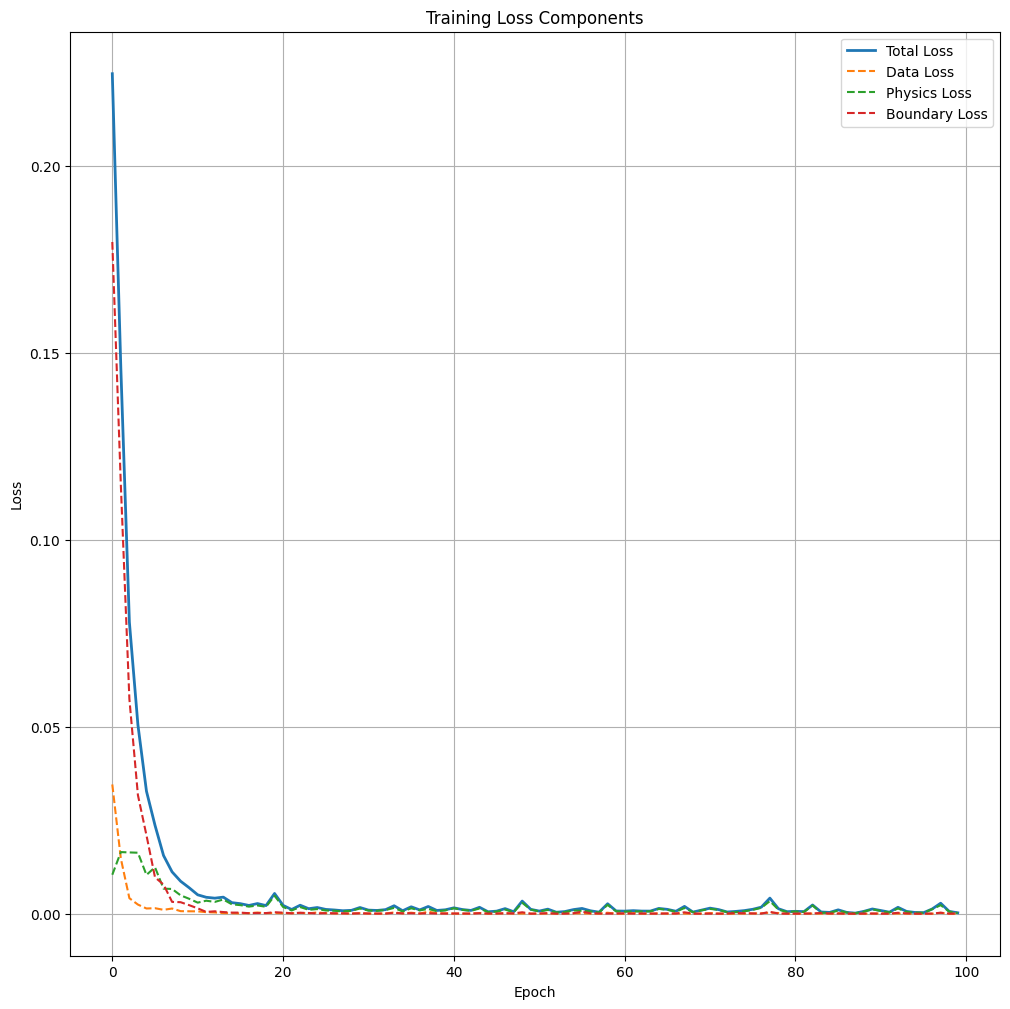

In [26]:
# Визуализация
plt.figure(figsize=(12, 12))
plt.plot(loss_history, label='Total Loss', linewidth=2)
plt.plot(base_loss_history, label='Data Loss', linestyle='--')
plt.plot(phy_loss_history, label='Physics Loss', linestyle='--')
plt.plot(bdry_loss_history, label='Boundary Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True)
plt.show()

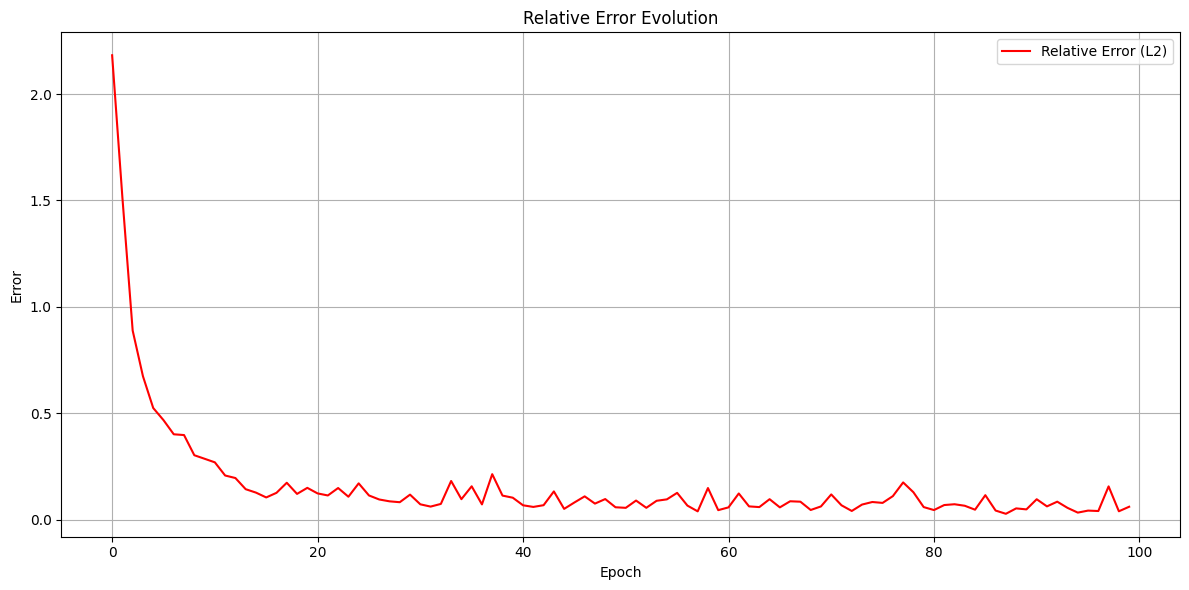

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(rel_error_history, label='Relative Error (L2)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Relative Error Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


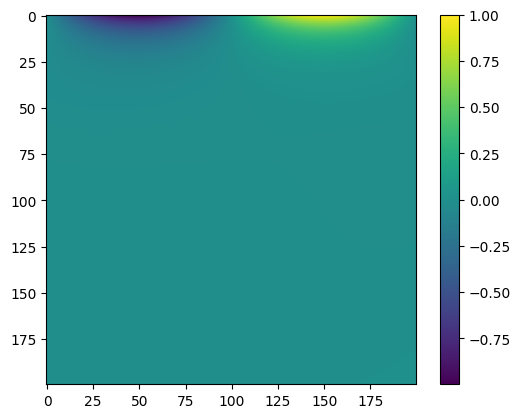

In [17]:
def u_model_pinn(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0, 1, pts)
xs = torch.linspace(-1, 1, pts)

X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()